## Welcome to the `Intro to Segmentation` Workshop!
In this workshop, we'll learn the concept of how to use FCN (Fully convolutional Networks)for Semantic Segmentation  Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a custom model with pretrained backbone
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

In [ ]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.8 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 376 kB 31.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=cf3290f91cdc9da069f7594aaf1ce38825f1c2c3efe0de79b613d5f3f9dcb890
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=03aaf02b7c5d703f46a02a3854013e9f796df33d38e0eeaea6776f947832a0d5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Basic Imports

In [ ]:
# basic imports
import random
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")
dataset_path = 'dataset'
output_path = 'dataset'

Mounted at /content/drive


In [ ]:
images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


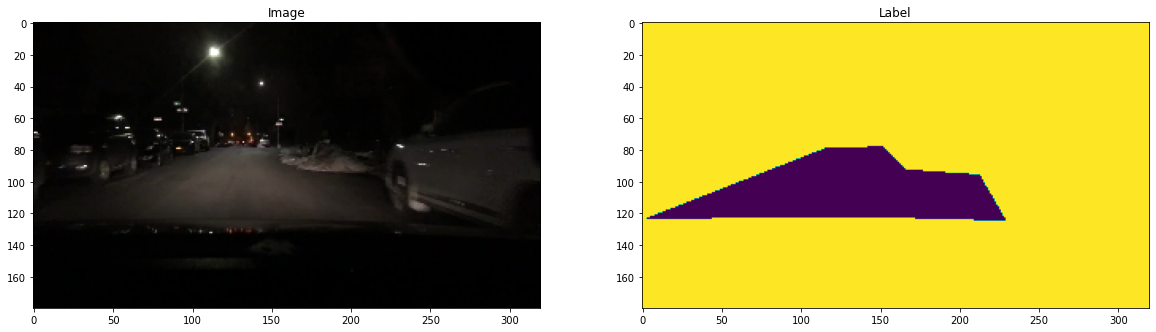

In [ ]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=458
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

### Build a Dataset & Dataloader

In [ ]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

In [ ]:
from torchvision import transforms
from collections import namedtuple

In [ ]:
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])


# Constants for Standard color mapping
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py

Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [ 
             Label("direct", 0, (219, 94, 86)),        # red
             Label("alternative", 1, (86, 211, 219)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black          
            ]
train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

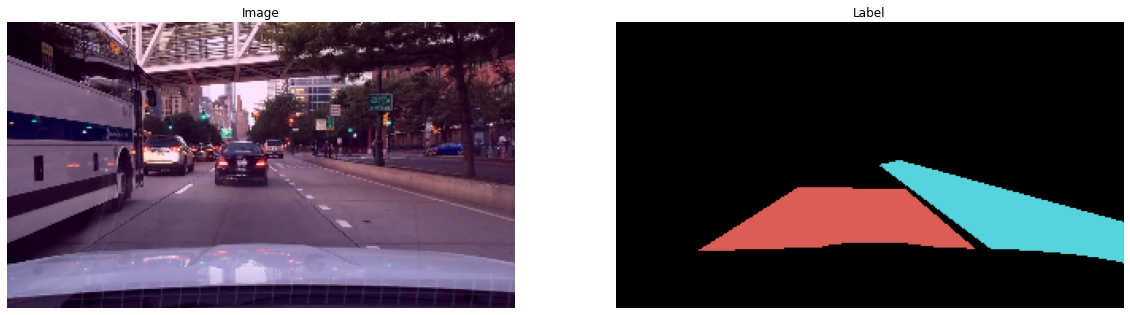

In [ ]:
#from utils import inverse_transform, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# 2. Network : Define a custom model with pretrained backbone

Below image shows the FCN architecture. The main components are:
- Pretrained Resnet50 backbone
- Classifier (custom Conv2d, BatchNorm2d, ReLU layers)
- Upsampling using Bilinear interpolation

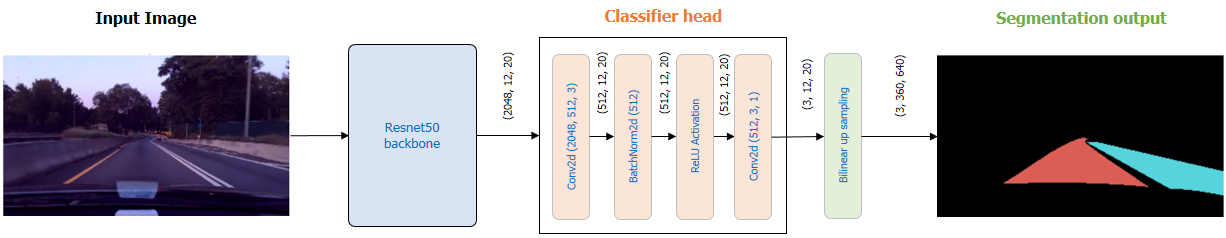

In [ ]:
from torchvision.models import resnet50

class FCN_resnet50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # feature extractor
        self.backbone = resnet50(pretrained=True)

        # layer4 of resnet50 has 2048 layers output
        backbone_output_channels = 2048
        # classifier will have 512 layers
        classifier_channels = 512

        # Classifier head
        self.classifier = nn.Sequential(
                nn.Conv2d(backbone_output_channels, classifier_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(classifier_channels),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(classifier_channels, num_classes, 1)
                )
    
    def forward(self, x):
        # get input shape for upsampling
        input_shape = x.shape[-2:]

        # pass input through the backbone layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # classifier output shape = (batch_size, num_classes, feat_ext_height, feat_ext_width)
        x = self.classifier(x)

        # upsample the classfier output to input shape
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

## Points to Note
1. The **Original FCN architecture used VGG-16 backbone** - which we have replaced with Resnet50. Similarly, there are variants with Resnet101 etc
2. **Skip connection idea was proposed in FCN**, but with VGG16 architecture. Since Resnet variants already have skip-connections, we haven't used here.
3. Here, we have used Bilinear interpolation for getting final prediction. One can experiment with `Transposed Convolutions` too
4. **Output from default resnet backbone is  32 times smaller than input image. -> referred as OS (Output Stride)**. Hence this variant of FCN is called **FCN32**

# 3. Training : Train and validate model on the custom dataset


Before we train our model, we'll define some helper functions to train, validate and plot training etc

## Function to plot training curves

In [ ]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

## Train validate function

In [ ]:
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)                
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [ ]:
def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

## Model Training

Starting 1 epoch ...


100%|██████████| 86/86 [00:14<00:00,  6.13it/s]


Epoch: 1, trainLoss:0.61960, validationLoss:0.44452, meanIoU: 0.59
Starting 2 epoch ...


100%|██████████| 86/86 [00:12<00:00,  6.66it/s]


Epoch: 2, trainLoss:0.35607, validationLoss:0.45825, meanIoU: 0.63
Starting 3 epoch ...


100%|██████████| 86/86 [00:13<00:00,  6.57it/s]


Epoch: 3, trainLoss:0.24440, validationLoss:0.29961, meanIoU: 0.69


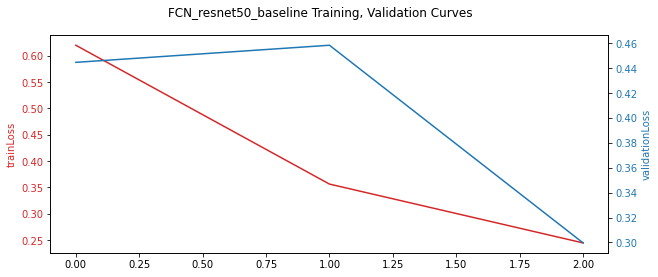

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

from utils import meanIoU
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 3
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'FCN_resnet50_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = FCN_resnet50(num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
# best_model = torch.jit.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device)
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:06<00:00,  6.43it/s]


Model has 0.6956529519908002 mean IoU in test set


In [ ]:
def visualize_predictions(model, dataSet, device, numTestSamples):
    """Function visualizes predictions of input model on samples from
    cityscapes dataset provided """
    model.to(device=device)
    model.eval()

    # predictions on random samples
    testSamples = np.random.choice(len(dataSet), numTestSamples).tolist()
    _, axes = plt.subplots(numTestSamples, 3, figsize=(3*6, numTestSamples * 4))
    
    for i, sampleID in enumerate(testSamples):
        inputImage, gt = dataSet[sampleID]

        # input rgb image   
        inputImage = inputImage.to(device)
        landscape = inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()
        axes[i, 0].imshow(landscape)
        axes[i, 0].set_title("Landscape")

        # groundtruth label image
        label_class = gt.cpu().detach().numpy()
        axes[i, 1].imshow(train_id_to_color[label_class])
        axes[i, 1].set_title("Groudtruth Label")

        # predicted label image
        y_pred = torch.argmax(model(inputImage.unsqueeze(0)), dim=1).squeeze(0)
        label_class_predicted = y_pred.cpu().detach().numpy()    
        axes[i, 2].imshow(train_id_to_color[label_class_predicted])
        axes[i, 2].set_title("Predicted Label")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


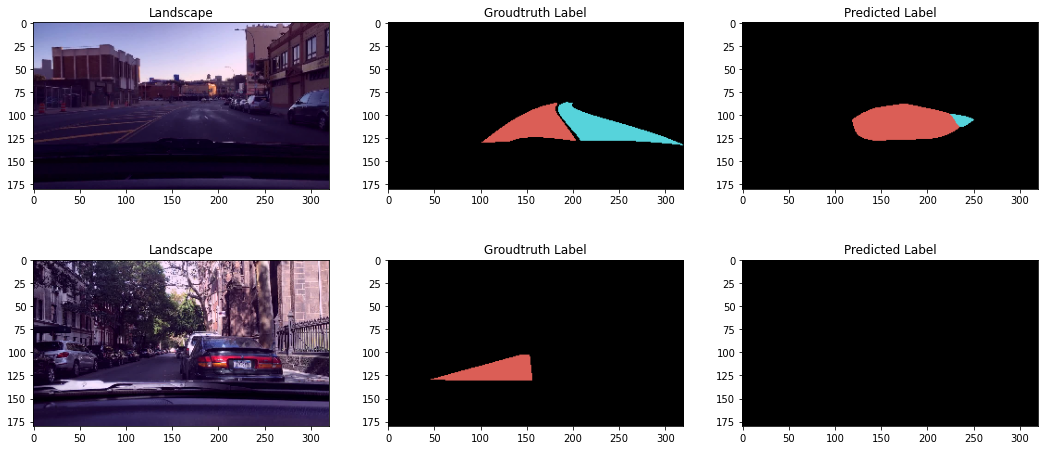

In [ ]:
visualize_predictions(model, test_set, device, numTestSamples=2)

## Test on sample video

You can try out the trained models on the Costa Rica challenge and Paris datasets, very different with lot of shadows and road surface compared to training set. Here's a helper function to test your model

```python
from utils import preprocess

def predict_video(model, model_name, input_video_path, output_dir, 
            target_width, target_height, device):
    file_name = input_video_path.split(os.sep)[-1].split('.')[0]
    output_filename = f'{file_name}_{model_name}_output.avi'
    output_video_path = os.path.join(output_dir, *[output_filename])

    # handles for input output videos
    input_handle = cv2.VideoCapture(input_video_path)
    output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), \
                                    30, (target_width, target_height))

    # create progress bar
    num_frames = int(input_handle.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total = num_frames, position=0, leave=True)

    while(input_handle.isOpened()):
        ret, frame = input_handle.read()
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # create torch tensor to give as input to model
            pt_image = preprocess(frame)
            pt_image = pt_image.to(device)

            # get model prediction and convert to corresponding color
            y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
            predicted_labels = y_pred.cpu().detach().numpy()
            cm_labels = (train_id_to_color[predicted_labels]).astype(np.uint8)

            # overlay prediction over input frame
            overlay_image = cv2.addWeighted(frame, 1, cm_labels, 0.25, 0)
            overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

            # write output result and update progress
            output_handle.write(overlay_image)
            pbar.update(1)

        else:
            break

    output_handle.release()
    input_handle.release()

costa_rica_path = 'videos/costa_rica_challenge_360_640.avi'
predict_video(model, MODEL_NAME, video_path, '.',targetWidth , targetHeight, device)
```

In [ ]:
from IPython.display import HTML
HTML("""
    <video alt="test" controls>
        <source src="videos/costa_rica_challenge_360_640_FCN_resnet50_baseline_output.avi" type="video/mp4">
    </video>
""")